In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
tesla = pd.read_csv('../dataset/TSLA.csv')
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
1,2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2,2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
3,2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
4,2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001


In [3]:
def df_shift(df,lag=0, start=1, skip=1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(start,lag+1,skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = (skip - 1)
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=skip
        df = pd.concat([df, dfn], axis=1)
    return df

In [4]:
tesla = tesla[['Date','Close']]
tesla.head(1)

,Date,Close
0,2020-01-02,86.052002


In [5]:
df_crosscorrelated = df_shift(tesla, lag = 10, start = 1, skip = 2,rejected_columns=['Date'])
df_crosscorrelated['ma7'] = df_crosscorrelated['Close'].rolling(7).mean()
df_crosscorrelated['ma14'] = df_crosscorrelated['Close'].rolling(14).mean()
df_crosscorrelated['ma25'] = df_crosscorrelated['Close'].rolling(25).mean()
df_crosscorrelated.head(10)

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,ma7,ma14,ma25
0,2020-01-02,86.052002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,88.601997,86.052002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-06,90.307999,88.601997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-07,93.811996,90.307999,86.052002,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-08,98.428001,93.811996,88.601997,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-01-09,96.267998,98.428001,90.307999,86.052002,NaN,NaN,NaN,NaN,NaN
6,2020-01-10,95.629997,96.267998,93.811996,88.601997,NaN,NaN,92.728570,NaN,NaN
7,2020-01-13,104.972000,95.629997,98.428001,90.307999,86.052002,NaN,95.431427,NaN,NaN
8,2020-01-14,107.584000,104.972000,96.267998,93.811996,88.601997,NaN,98.143142,NaN,NaN
9,2020-01-15,103.699997,107.584000,95.629997,98.428001,90.307999,86.052002,100.056284,NaN,NaN


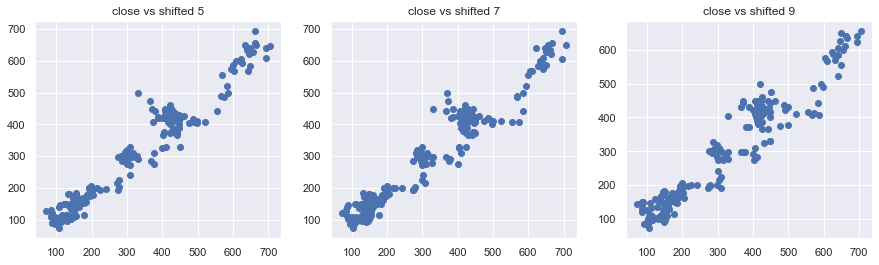

In [6]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'])
plt.title('close vs shifted 5')
plt.subplot(1,3,2)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'])
plt.title('close vs shifted 7')
plt.subplot(1,3,3)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'])
plt.title('close vs shifted 9')
plt.show()

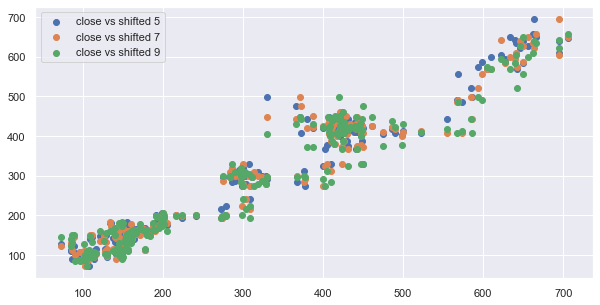

In [7]:
plt.figure(figsize=(10,5))
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'],label='close vs shifted 5')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'],label='close vs shifted 7')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'],label='close vs shifted 9')
plt.legend()
plt.show()

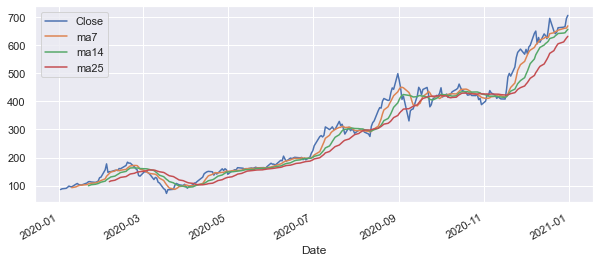

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated.plot(x='Date',y=['Close','ma7','ma14','ma25'],ax=ax)
plt.show()

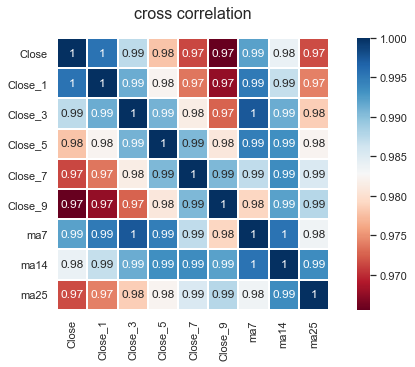

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 5))
ax=plt.subplot(111)
plt.title('cross correlation', y=1.05, size=16)
selected_column = ['Close','Close_1','Close_3','Close_5','Close_7','Close_9','ma7','ma14','ma25']

sns.heatmap(df_crosscorrelated[selected_column].corr(), ax=ax, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

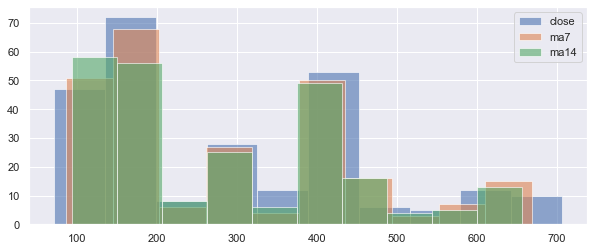

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated['Close'].hist(alpha=0.6,label='close',ax=ax)
df_crosscorrelated['ma7'].hist(alpha=0.6,label='ma7',ax=ax)
df_crosscorrelated['ma14'].hist(alpha=0.6,label='ma14',ax=ax)
plt.legend()
plt.show()

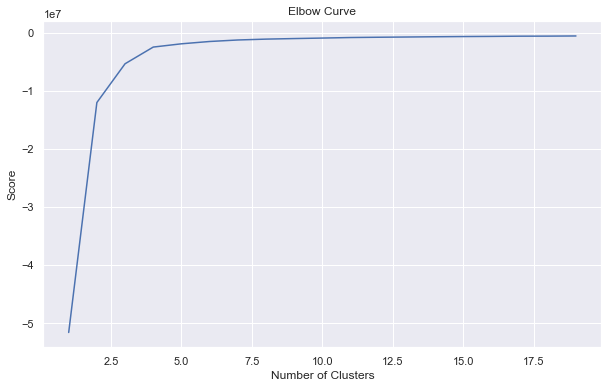

In [11]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
data = df_crosscorrelated.iloc[:,1:].dropna().values
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

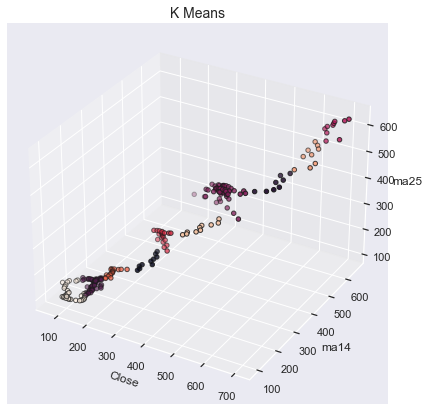

In [12]:
from mpl_toolkits.mplot3d import Axes3D

X = df_crosscorrelated[['Close','ma14','ma25']].dropna()
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_


fig = plt.figure(1, figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")

ax.set_xlabel("Close")
ax.set_ylabel("ma14")
ax.set_zlabel("ma25")
plt.title("K Means", fontsize=14)
plt.show()


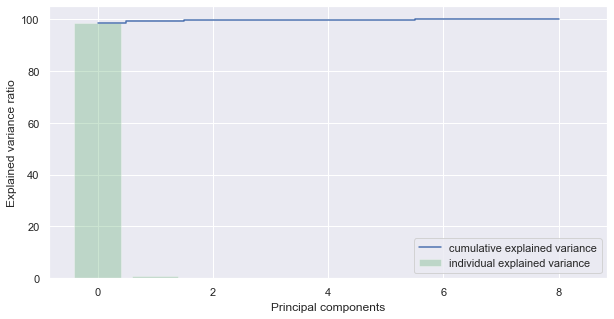

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [14]:
X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
pca = PCA(n_components=2)
data = pca.fit_transform(data)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

- do a K-means clustering on the first 2 Principal components

In [15]:
df = df_crosscorrelated.dropna()
kmeans = KMeans(n_clusters=10).fit(np_scaled)
df['cluster'] = kmeans.predict(np_scaled)
df = df.reset_index()
df.loc[:,'principal_feature1'] = np_scaled[:,0]
df.loc[:,'principal_feature2'] = np_scaled[:,1]
df['cluster'].value_counts()

<ipython-input-15-b414d2118a0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(np_scaled)


1    65
0    29
4    26
5    21
3    19
8    19
7    17
2    14
6    14
9     5
Name: cluster, dtype: int64

In [16]:
kmeans.cluster_centers_

array([[ 0.80674859, -0.5247443 ],
       [-0.91212049,  0.04234555],
       [ 1.28099626,  0.98799858],
       [-1.02536069, -1.03992163],
       [-0.72843691,  0.74404753],
       [ 0.78385463, -1.6372984 ],
       [ 2.13127403, -0.16748386],
       [ 0.01299566, -0.55265435],
       [ 0.18642434,  1.70029813],
       [ 1.26352303,  2.57278375]])

In [17]:
def getDistanceByPoint(data, model):
    distance = pd.Series(np.zeros( (len(data)) ))
    for i in range(0,len(data)):
        Xa = data[i]
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance[i] = np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.1
distance = getDistanceByPoint(np_scaled, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly1'] = (distance >= threshold).astype(int)

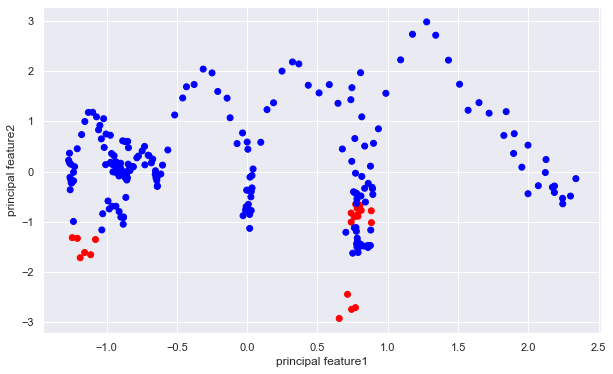

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show()

In [19]:
df.anomaly1.value_counts()

0    207
1     22
Name: anomaly1, dtype: int64

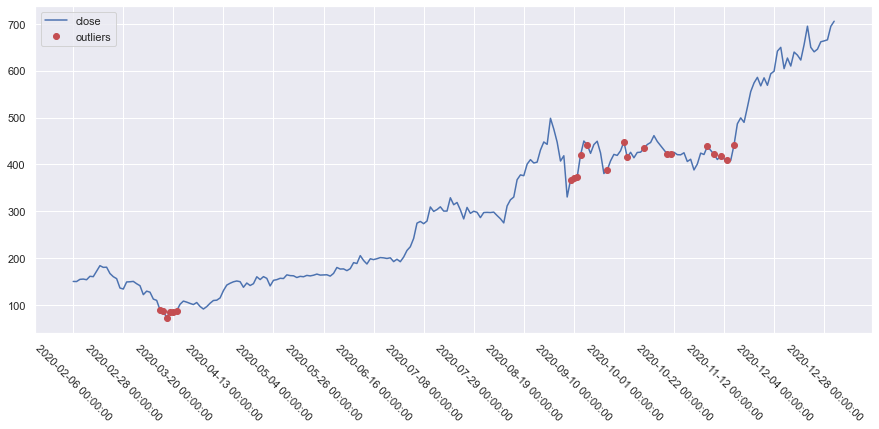

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='close',c='b')
plt.plot(df['Close'], 'o', label='outliers',markevery=df.loc[df['anomaly1'] == 1].index.tolist(),c='r')
plt.xticks(np.arange(df.shape[0])[::15],df['Date'][::15],rotation='-45')
plt.legend()
plt.show()

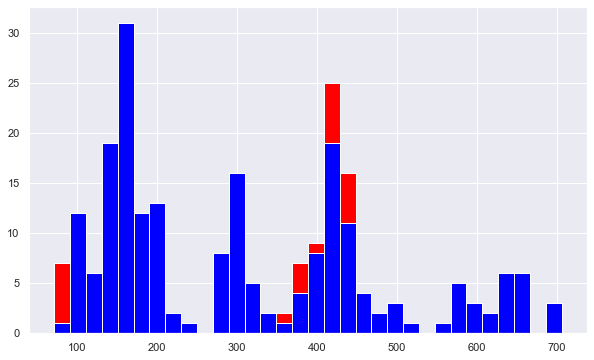

In [21]:
a = df.loc[df['anomaly1'] == 0, 'Close']
b = df.loc[df['anomaly1'] == 1, 'Close']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

In [22]:
ori_len = df_crosscorrelated.shape[0] - X.shape[0]
ori_len

24

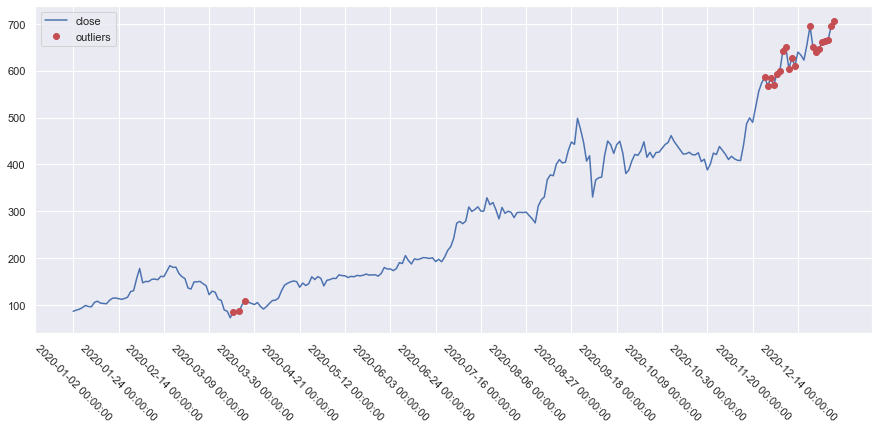

In [23]:
from sklearn.ensemble import IsolationForest

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)

model = IsolationForest(contamination=outliers_fraction)
model.fit(np_scaled)
outliers = model.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',
         markevery=(np.where(outliers==-1)[0] + ori_len).tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

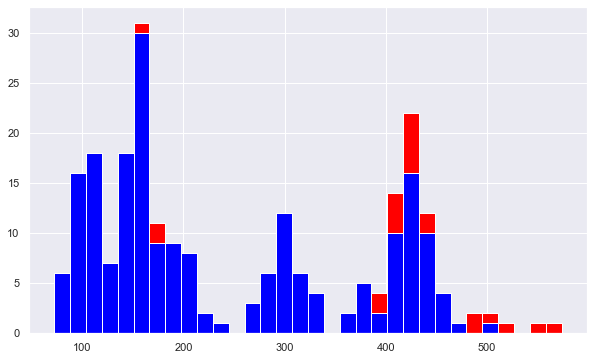

In [24]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

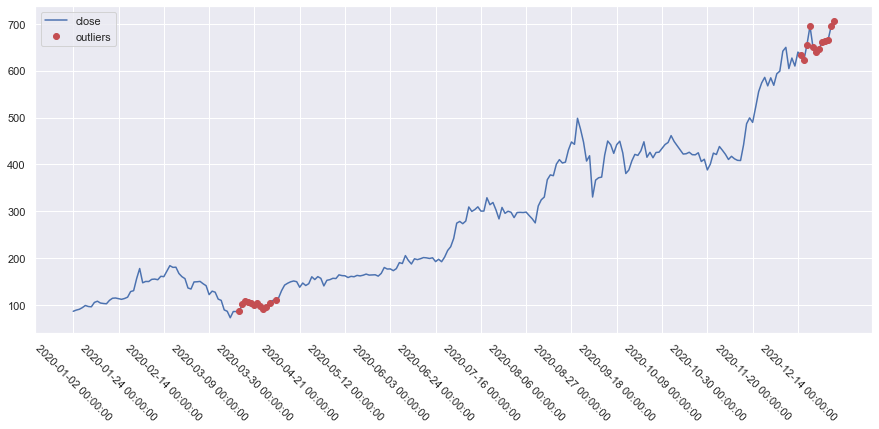

In [25]:
from sklearn.svm import OneClassSVM

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(np_scaled)
outliers = model.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',
         markevery=(np.where(outliers==-1)[0] + ori_len).tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

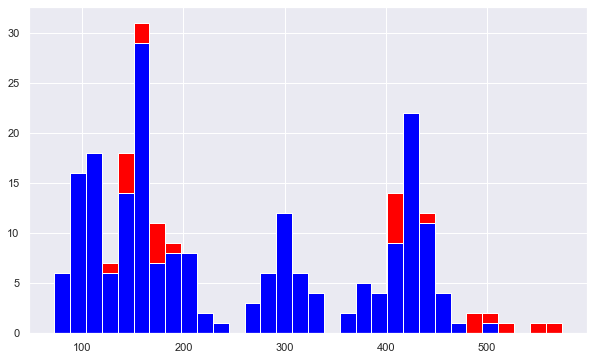

In [26]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

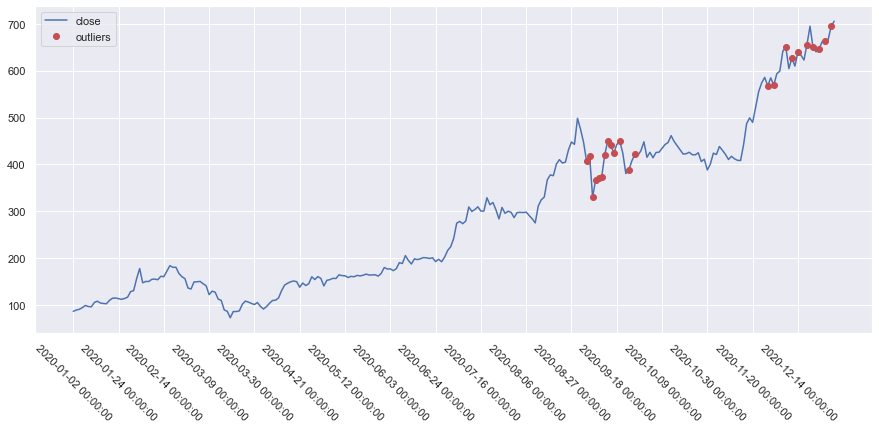

In [27]:
from sklearn.covariance import EllipticEnvelope

envelope = EllipticEnvelope(contamination = outliers_fraction)
X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
envelope.fit(np_scaled)
outliers = envelope.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',
         markevery=(np.where(outliers==-1)[0] + ori_len).tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

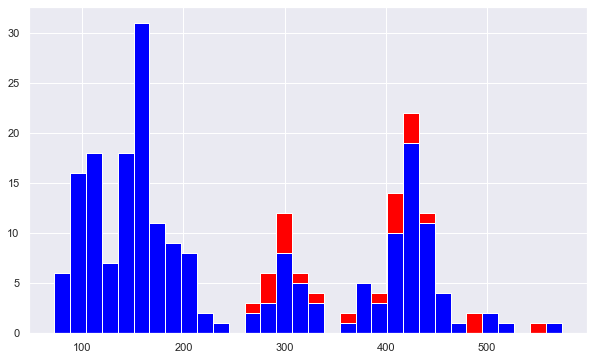

In [28]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()